In [1]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""

import json
import matplotlib.pyplot as plt
import numpy as np
import pystan
import random
import seaborn as sns 
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pickle
from textblob import TextBlob

In [2]:
baseline="""

data {
      int<lower=1> I; // number of products
      int<lower=1> N; // number of reviews
      int<lower=1> J; // number of reviewers
      vector<lower=0> [N] scores; // review scores vector
      int reviewerID[N]; // reviewer ID for each review
      int prodID[N]; // product ID for each review
}

parameters {
    vector [I] truescore;
    vector [J] reviewbias;
    real<lower=0> c;
    real<lower=0> d;
}

model {
    c ~ gamma(1,1);
    truescore ~ normal(3,1); // TODO: change hyperparameters for data 
    reviewbias ~ normal(0, 1/c);
    for (i in 1:N) {
        scores[i] ~ normal(truescore[prodID[i]] + reviewbias[reviewerID[i]], 1);
        } 
    }

"""

In [3]:
model1="""
data {
    int<lower=1> I; // number of products
    int<lower=1> N; // number of reviews
    int<lower=1> J; // number of reviewers
    vector<lower=0> [N] scores; // review scores vector 
    int reviewerID[N]; // reviewer ID for each review
    int prodID[N]; // product ID for each review
}
parameters {
    vector [I] truescore;
    vector [J] reviewbias;
    real<lower=0> c;
    real<lower=0> d;
}
model {
    c ~ gamma(1,1);
    d ~ gamma(1,1);
    truescore ~ normal(3,1); // TODO: change hyperparameters for data 
    reviewbias ~ normal(0, 1/c);
    for (i in 1:N) {
       scores[i] ~ normal(truescore[prodID[i]]+ reviewbias[reviewerID[i]], 1/d);
    }
}

"""

In [4]:
model2="""
data {
    int<lower=1> I; // number of products
    int<lower=1> N; // number of reviews
    int<lower=1> J; // number of reviewers
    vector<lower=0> [N] scores; // review scores vector 
    vector<lower=0> [N] sentscore; // review sentiment score 
    int reviewerID[N]; // reviewer ID for each review
    int prodID[N]; // product ID for each review
}
parameters {
    vector [I] truescore;
    vector [J] reviewbias;
    real<lower=0> c;
    real<lower=0> d;
}
model {
    c ~ gamma(1,1);
    d ~ gamma(1,1);
    truescore ~ normal(4.11,1.26); // TODO: change hyperparameters for data 
    reviewbias ~ normal(0, 1/c);
    for (i in 1:N) {
        scores[i] ~ normal(truescore[prodID[i]]+reviewbias[reviewerID[i]], (sentscore[i])/d);
} 
}
"""

In [5]:
model3="""
data {
    int<lower=1> I; // number of products
    int<lower=1> N; // number of reviews
    int<lower=1> J; // number of reviewers
    vector<lower=0> [N] scores; // review scores vector 
    vector<lower=0> [N] helpfulness; // helpfulness score 
    int reviewerID[N]; // reviewer ID for each review
    int prodID[N]; // product ID for each review
}
parameters {
    vector [I] truescore;
    vector [J] reviewbias;
    real<lower=0> c;
    real<lower=0> d;
}
model {
    c ~ gamma(1,1);
    d ~ gamma(1,1);
    truescore ~ normal(4.11,1.26); // TODO: change hyperparameters for data 
    reviewbias ~ normal(0, 1/c);
    for (i in 1:N) {
        scores[i] ~ normal(truescore[prodID[i]]+reviewbias[reviewerID[i]], 1/((1+helpfulness[i])*d));
} 
}
"""

In [6]:
model4="""
data {
    int<lower=1> I; // number of products
    int<lower=1> N; // number of reviews
    int<lower=1> J; // number of reviewers
    vector<lower=0> [N] scores; // review scores vector 
    vector<lower=0> [N] helpfulness; // helpfulness score 
    int reviewerID[N]; // reviewer ID for each review
    int prodID[N]; // product ID for each review
}
parameters {
    vector [I] truescore;
    vector [J] reviewbias;
    real<lower=0> c;
    real<lower=0> d;
}
model {
    c ~ gamma(1,1);
    d ~ gamma(1,1);
    truescore ~ normal(4.11,1.26); // TODO: change hyperparameters for data 
    reviewbias ~ normal(0, 1/c);
    for (i in 1:N) {
        scores[i] ~ normal(truescore[prodID[i]]+reviewbias[reviewerID[i]], 1/d);
} 
}
"""


In [ ]:
model5="""
data {
    int<lower=1> I; // number of products
    int<lower=1> N; // number of reviews
    int<lower=1> J; // number of reviewers
    vector<lower=0> [N] scores; // review scores vector 
    vector<lower=0> [N] sentscore; // sentiment score 
    int reviewerID[N]; // reviewer ID for each review
    int prodID[N]; // product ID for each review
}
parameters {
    vector [I] truescore;
    vector [J] reviewbias;
    real<lower=0> c;
    real<lower=0> d;
}
model {
    c ~ gamma(1,1);
    d ~ gamma(1,1);
    truescore ~ normal(4.11,1.26); // TODO: change hyperparameters for data 
    reviewbias ~ normal(0, 1/c);
    for (i in 1:N) {
        scores[i] ~ normal(truescore[prodID[i]]+reviewbias[reviewerID[i]]+sentscore[i], 1/d);
} 
}
"""


In [30]:
def store_data(file,db):
    '''file = name of pickle file'''
    dbfile = open(file, 'wb')
    # source, destination 
    pickle.dump(db, dbfile)
    dbfile.close()
    
    
def load_data(file): 
    '''file = name of pickle file'''    
    dbfile = open(file, 'rb')
    db = pickle.load(dbfile)
    dbfile.close() 
    return db
 

In [70]:
def plot_bias(rusers,fit_df):
    reviewers = len(rusers)
    rb_ind = []
    i = 1
#     for i in range(20):
#     rb_num = random.randint(1,reviewers)
#     while rb_num in rb_ind:
#         rb_num = random.randint(1,reviewers)
    rb_num =i
    str_ind = "reviewbias["+str(rb_num)+']'
    reviewer_bias_ind_plt = fit_df[str_ind]   
    rb_ind.append(rb_num)        
    plt.subplots(figsize=(15,3))
    plt.subplot(1,4,1)
    sns.kdeplot(reviewer_bias_ind_plt)
    return

In [71]:
def plot_goodness(rproducts,fit_df):
    prod = len(rproducts)
    prod_ind = []
    i = 1
#     for i in range(1):
#         prod_num = random.randint(1,prod)
#         while prod_num in prod_ind:
#             prod_num = random.randint(1,prod)
    prod_num = i
    str_ind = "truescore["+str(prod_num)+']'
    prod_ind_plt = fit_df[str_ind]   
    prod_ind.append(prod_num)        
    plt.subplots(figsize=(15,3))
    plt.subplot(1,4,1)
    sns.kdeplot(prod_ind_plt)
    return

In [13]:
def sentiment_analyzer_scores(analyser,sentence):
    score = analyser.polarity_scores(sentence)
    cscore=score['compound']
    inputlow=-1
    inputhigh=1
    outputlow=1
    outputhigh=5
    cscore=((cscore-inputlow)/(inputhigh-inputlow))*(outputhigh-outputlow)+outputlow
    return cscore
    
def rescale(cscore,inputlow=-1,inputhigh=1,outputlow=1,outputhigh=5):
    cscore=((cscore-inputlow)/(inputhigh-inputlow))*(outputhigh-outputlow)+outputlow
    return cscore
#     Result := ((Input - InputLow) / (InputHigh - InputLow))
#           * (OutputHigh - OutputLow) + OutputLow;

def getSentimentScore(review):
    analyser = SentimentIntensityAnalyzer()
    score=sentiment_analyzer_scores(analyser,review)
    return score

def getSm_tb_Score(review):
    '''Sentiment scores using textblob'''
    blob = TextBlob(review)
    score = blob.sentiment.polarity
    score = rescale(score)
    return score

# def getReviewQuality(rating,sscore):
    
    
#     rq=1/(abs(rating-sscore)+1e-3)
#     inputlow=1/(4+1e-3)
#     inputhigh=1/(1e-3)
#     outputlow=1
#     outputhigh=2
#     rp=((rq-inputlow)/(inputhigh-inputlow))*(outputhigh-outputlow)+outputlow
#     print(str(rq)+" "+str(abs(rating-sscore))+" "+str(rp))
#     return rp

def getReviewQuality(rating,sscore):
    deviation = abs(rating-sscore)
    inputlow = 0
    inputhigh = 4
    outputlow = 1
    outputhigh = 2
    rp=((deviation-inputlow)/(inputhigh-inputlow))*(outputhigh-outputlow)+outputlow
#     print(str(rq)+" "+str(abs(rating-sscore))+" "+str(rp))
    return rp

In [14]:
path='reviews_Amazon_Instant_Video_5.json'

data=[]
for line in open(path,'r'):
    data.append(json.loads(line))

products={}
for d in data:
    if d['asin'] not in products:
        products[d['asin']] = [d]
    else:
        products[d['asin']].append(d)

users={}
for d in data:
    if d['reviewerID'] not in users:
        users[d['reviewerID']] = [d]
    else:
        users[d['reviewerID']].append(d)

print('No of reviews',len(data))   
print('No of reviewers',len(users))  
print('No. of products reviewed',len(products.keys()))

count1=0
rusers={}
for key in users.keys():
    
    if len(users[key])>10:
        pr=[]
        diff=0
        for i in users[key]:
            if i['asin'] not in pr:
                pr.append(i['asin'])
            else:
                diff+=1
        if(len(users[key])-diff>10):
            count1+=1
            rusers[key]=users[key]
                
print('No of users with more than 10 reviews',count1)

count2=0
rproducts={}
for key in products.keys():
    
    if len(products[key])>10:
        ur=[]
        diff=0
        for i in products[key]:
            if i['reviewerID'] not in ur:
                ur.append(i['reviewerID'])
            else:
                diff+=1
        if(len(products[key])-diff>10):
            count2+=1
            rproducts[key]=products[key]


print('No of products with more than 10 reviews',count2)

print("Reduced users",len(rusers))
print("Reduced products",len(rproducts))


rmap={}
pmap={}
rcount=1
pcount=1

for key in rusers.keys():
    rmap[key]=rcount
    rcount+=1

for key in rproducts.keys():
    pmap[key]=pcount
    pcount+=1


reviewer=[]
product=[]
ratings=[]
helpful=[]
reviewQuality=[]
reviewText=[]
sent_score=[]
sent_tb_score = [] #sentiment_analysis score using textblob
reviewQuality_tb = [] #rq using textblob

for key in rusers.keys():
    for prod in rusers[key]:
        
        if prod['asin'] in rproducts:
            reviewer.append(rmap[key])
            product.append(pmap[prod['asin']])
            ratings.append(prod['overall'])
            s_score=getSentimentScore(prod['reviewText'])
            s_tb_score = getSm_tb_Score(prod['reviewText'])
            sent_score.append(s_score)
            sent_tb_score.append(s_tb_score)
            rq=getReviewQuality(prod['overall'],s_score)
            rq_tb=getReviewQuality(prod['overall'],s_tb_score)            
            reviewQuality.append(rq)
            reviewQuality_tb.append(rq_tb)
            reviewText.append(prod['reviewText'])
            hrating=prod['helpful'][0]+prod['helpful'][1]
            if hrating==0:
                hrating=0
            else:
                hrating=prod['helpful'][0]/hrating
            helpful.append(hrating+1)
            
d=[reviewer,product,ratings,helpful,reviewQuality,reviewText,reviewQuality_tb]

ind=[]
for i in range(len(d[0])):
    ind.append(i)
random.shuffle(ind)

sdata=[[],[],[],[],[],[],[]]
for i in ind:
    for j in range(len(sdata)):
        sdata[j].append(d[j][i])

prod=set()
for p in sdata[1]:
    prod.add(p)
# print(len(prod))

# reviewQuality_tb = reviewQuality_tb[:5000]

training_data=[sdata[0][:5000],sdata[1][:5000],sdata[2][:5000],sdata[3][:5000],sdata[4][:5000],sdata[5][:5000],sdata[6][:5000]]
test_data=[sdata[0][5000:],sdata[1][5000:],sdata[2][5000:],sdata[3][5000:],sdata[4][5000:],sdata[5][5000:],sdata[6][5000:]]


No of reviews 37126
No of reviewers 5130
No. of products reviewed 1685
No of users with more than 10 reviews 511
No of products with more than 10 reviews 810
Reduced users 511
Reduced products 810


In [31]:
'''Pickling train and test data'''
store_data("tr_test",[training_data,test_data])

In [15]:
# tr_test = load_data("tr_test")
# training_data = tr_test[0]
# test_data = tr_test[1]

train_users=set()
for t in training_data[0]:
    train_users.add(t)
print(len(train_users))

train_products=set()
for p in training_data[1]:
    train_products.add(p)
print(len(train_products))
#print(training_data[4])

511
768


In [16]:
count=0
for t in range(len(training_data[2])):
    print(training_data[2][t],training_data[4][t])
    if (abs(training_data[2][t]-sent_score[t]) > 2):
        #print(training_data[5][t])
        count+=1
print((len(training_data[2])-count)/len(training_data[2]))

5.0 1.00775
4.0 1.20465
5.0 1.1705
4.0 1.7358
4.0 1.186
5.0 1.0642
4.0 1.2450999999999999
5.0 1.73505
4.0 1.23255
4.0 1.0399500000000002
3.0 1.46375
4.0 1.17775
5.0 1.7294
4.0 1.24725
4.0 1.2393
5.0 1.0584
5.0 1.1130499999999999
4.0 1.03595
5.0 1.0205
5.0 1.0345
4.0 1.21905
5.0 1.1875499999999999
5.0 1.04
5.0 1.1206
5.0 1.05215
5.0 1.0377
3.0 1.3592
2.0 1.73945
5.0 1.01685
4.0 1.335
5.0 1.0943
4.0 1.1721
5.0 1.0011
4.0 1.24625
5.0 1.12995
5.0 1.1108500000000001
5.0 1.03185
5.0 1.1278000000000001
4.0 1.6388
5.0 1.01065
5.0 1.4373
4.0 1.69195
5.0 1.15175
5.0 1.0238
5.0 1.19115
5.0 1.03995
5.0 1.024
5.0 1.9228
3.0 1.4396499999999999
2.0 1.6055
5.0 1.0284
5.0 1.03745
5.0 1.11765
4.0 1.0642
5.0 1.0037
3.0 1.1448
3.0 1.4356499999999999
3.0 1.48645
2.0 1.2345
5.0 1.00145
5.0 1.0423499999999999
3.0 1.49335
3.0 1.4447
5.0 1.9485000000000001
5.0 1.1029499999999999
5.0 1.13655
5.0 1.01045
4.0 1.1955
5.0 1.1452
4.0 1.1711
3.0 1.4053
4.0 1.24665
5.0 1.0239500000000001
4.0 1.13685
3.0 1.3243
5.0 1.0

4.0 1.10015
5.0 1.0061
4.0 1.6875
5.0 1.1938
3.0 1.4811
4.0 1.73065
3.0 1.4445000000000001
5.0 1.17365
5.0 1.27305
5.0 1.06105
1.0 1.1041
5.0 1.0248
5.0 1.0283
5.0 1.07595
1.0 1.98305
5.0 1.2003
4.0 1.15335
5.0 1.0164
5.0 1.11415
4.0 1.2416
5.0 1.0472000000000001
5.0 1.01685
4.0 1.21835
2.0 1.2187000000000001
4.0 1.24955
3.0 1.44385
5.0 1.0545
4.0 1.1219000000000001
4.0 1.45675
3.0 1.49735
5.0 1.11225
5.0 1.099
5.0 1.20365
1.0 1.0383
4.0 1.6656
4.0 1.2459500000000001
3.0 1.1622
2.0 1.016
5.0 1.21305
4.0 1.18445
3.0 1.4932
5.0 1.00145
5.0 1.0284
3.0 1.41475
1.0 1.6287500000000001
5.0 1.0257
5.0 1.00865
5.0 1.09765
3.0 1.4884
4.0 1.1926
5.0 1.064
2.0 1.3977
5.0 1.02075
5.0 1.66695
4.0 1.2478500000000001
5.0 1.099
5.0 1.18155
5.0 1.2003
5.0 1.0503
2.0 1.04515
1.0 1.3243
1.0 1.12405
4.0 1.1562999999999999
5.0 1.1247
4.0 1.2434
3.0 1.4836
5.0 1.28925
4.0 1.1975500000000001
2.0 1.7159499999999999
5.0 1.02065
3.0 1.2300499999999999
5.0 1.0203
5.0 1.143
5.0 1.00815
4.0 1.4431
3.0 1.3291
5.0 1.

4.0 1.7428
3.0 1.47465
1.0 1.8195999999999999
5.0 1.0533000000000001
5.0 1.10645
5.0 1.0441
4.0 1.7356
3.0 1.20045
5.0 1.9886
5.0 1.0143
5.0 1.1575
3.0 1.49525
5.0 1.1966
4.0 1.22865
1.0 1.1393499999999999
4.0 1.23505
3.0 1.4385
4.0 1.2453
4.0 1.58525
4.0 1.16965
3.0 1.38995
5.0 1.02495
1.0 1.242
4.0 1.2489
5.0 1.0061
5.0 1.2213
4.0 1.0084
5.0 1.1047
4.0 1.15115
5.0 1.01235
3.0 1.4533
2.0 1.24045
1.0 1.0918
5.0 1.93055
5.0 1.06785
5.0 1.0142
5.0 1.2213
4.0 1.24025
5.0 1.0354
5.0 1.0072
5.0 1.18155
4.0 1.2076
5.0 1.1085
5.0 1.074
5.0 1.0365
1.0 1.91435
4.0 1.0826
5.0 1.00075
5.0 1.07415
5.0 1.0646499999999999
5.0 1.0446
5.0 1.0895000000000001
5.0 1.0039500000000001
3.0 1.1899
2.0 1.24485
5.0 1.0061499999999999
5.0 1.1018
5.0 1.1546
5.0 1.02885
5.0 1.0220500000000001
5.0 1.02085
4.0 1.15495
5.0 1.01885
3.0 1.4696500000000001
5.0 1.11415
3.0 1.4967
5.0 1.0289
2.0 1.0562
2.0 1.03235
5.0 1.00595
2.0 1.1301999999999999
1.0 1.0425499999999999
2.0 1.7298
5.0 1.01705
5.0 1.0449
5.0 1.0041
5.0 1

5.0 1.8841999999999999
2.0 1.70665
4.0 1.22825
1.0 1.2925
5.0 1.0479
5.0 1.0326
4.0 1.2457
5.0 1.07225
4.0 1.0954
5.0 1.9307
5.0 1.04725
4.0 1.2468
4.0 1.23465
5.0 1.0021499999999999
4.0 1.23025
4.0 1.1134
5.0 1.09125
5.0 1.0224
4.0 1.15125
5.0 1.97655
1.0 1.22885
4.0 1.1855
3.0 1.4062999999999999
5.0 1.02575
2.0 1.1360000000000001
2.0 1.2260499999999999
3.0 1.42775
5.0 1.0199
5.0 1.1218
5.0 1.02455
3.0 1.32105
4.0 1.24315
5.0 1.0131000000000001
3.0 1.48875
4.0 1.2099
5.0 1.02745
5.0 1.0140500000000001
5.0 1.2447
5.0 1.0912
5.0 1.28985
4.0 1.12365
5.0 1.58895
4.0 1.16585
5.0 1.0441
5.0 1.4857
5.0 1.0323
5.0 1.3091
5.0 1.01785
4.0 1.2278
4.0 1.24425
2.0 1.2293
2.0 1.23065
3.0 1.43125
4.0 1.2359499999999999
5.0 1.1762000000000001
5.0 1.8618999999999999
3.0 1.32645
4.0 1.6709
5.0 1.1126
5.0 1.0102
5.0 1.97255
4.0 1.1615
5.0 1.0179
5.0 1.0064
3.0 1.36345
4.0 1.2453
5.0 1.01675
4.0 1.2019
5.0 1.1793
3.0 1.4172500000000001
5.0 1.0769
5.0 1.02105
4.0 1.03925
5.0 1.2807
5.0 1.11935
5.0 1.02345

IndexError: index 10 is out of bounds for axis 0 with size 10

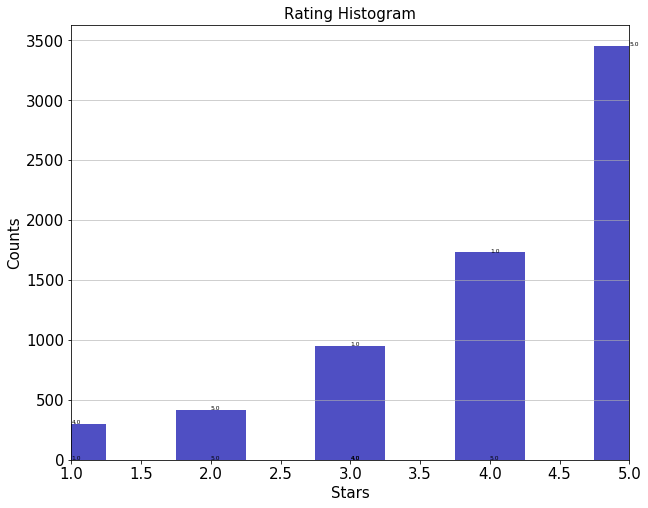

In [79]:
# plt.hist(ratings)
'''added code'''
plt.figure(figsize=[10,8])
# np_hist = [0,1,2,3,4,5]
# np_hist = np.random.normal(loc=0, scale=1, size=1000)
np_hist =ratings

hist,bin_edges = np.histogram(np_hist)

bin_edges = np.round(bin_edges,0)


plt.bar(bin_edges[:-1], hist, width = 0.5, color='#0504aa',alpha=0.7)
plt.xlim(min(bin_edges), max(bin_edges))
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Stars',fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Counts',fontsize=15)
plt.title('Rating Histogram',fontsize=15)


    
for i in range(len(ratings)):
    r = ratings[i]
    plt.text(x = bin_edges[i], y = hist[i]+0.1, s = str(ratings[i]), size = 6)



plt.show()


In [ ]:
r=np.array(training_data[2])
mean=np.mean(r)
var=np.var(r)
print(mean)
print(var+0.01)
plt.plot(r, stats.norm.pdf(r, mean, var))
plt.show()
qqplot(r, line='s')
plt.show()

In [18]:
def getRMSEscores(la,num):
    goodness=[]
    bias=[]
    gp=0
    bu=0
    for k in range(len(rproducts)):
        a=0
        for i in range(np.shape(la)[0]):
            for j in range(np.shape(la)[1]):
                a+=la[i][j][k]
        goodness.append(a/2000)
        gp+=(a/2000)
    for p in range(k+1,k+1+len(rusers)):
        a=0
        for i in range(np.shape(la)[0]):
            for j in range(np.shape(la)[1]):
                a+=la[i][j][p]
        bias.append(a/2000)
        bu+=(a/2000)
                  
    s=0
    for r in range(len(training_data[0])):
        rindex=training_data[0][r]-1
        pindex=training_data[1][r]-1
        a=(training_data[2][r]-goodness[pindex]-bias[rindex])**2
        s+=a
    s=(s/5000)**(0.5)
    print("Training RMSE for Model " + num,s)
    s=0

    #Testing RMSE for Model 1
    for r in range(len(test_data[0])):
        rindex=test_data[0][r]-1
        pindex=test_data[1][r]-1
        a=(test_data[2][r]-goodness[pindex]-bias[rindex])**2
        s+=a
    s=(s/len(test_data[0]))**(0.5)
    print("Testing RMSE for Model " + num,s)

In [65]:
#Baseline

base_data = {'I': 810, 'N': 5000, 'J':511, 'scores':training_data[2], 'reviewerID':training_data[0], 'prodID':training_data[1]}

sm = pystan.StanModel(model_code=baseline)

fit = sm.sampling(data=base_data, iter=1000, chains=4,warmup = 500)

# print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4dae8cd52da8500c9e3b044aad89f788 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [66]:
la = fit.extract(permuted=False)
getRMSEscores(la,"baseline")
# print(np.shape(la))

Training RMSE for Model baseline 0.8006345964694646
Testing RMSE for Model baseline 1.016991673517436


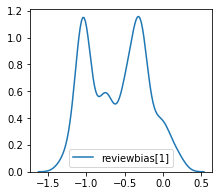

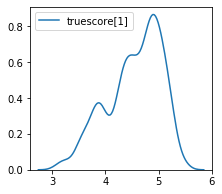

In [72]:
fit_df=fit.to_dataframe()
plot_bias(rusers,fit_df)
plot_goodness(rproducts,fit_df)

In [73]:
#Model 1(untuned priors with 1/d sd)
base_data = {'I': 810, 'N': 5000, 'J':511, 'scores':training_data[2], 'sentscore':training_data[4], 'reviewerID':training_data[0], 'prodID':training_data[1]}

sm = pystan.StanModel(model_code=model1)

fit = sm.sampling(data=base_data, iter=1000, chains=4,warmup = 500)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_43b4b4d7b8c6d300dbe8725b4fa103b0 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [74]:
la = fit.extract(permuted=False)
getRMSEscores(la,"1")


Training RMSE for Model 1 0.7745224131850729
Testing RMSE for Model 1 0.997910917232956


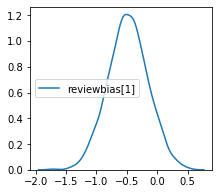

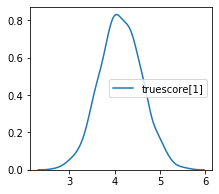

In [75]:
get_plots(fit)

In [76]:
#Model 2(Sentiment Analysis using Vader)
base_data = {'I': 810, 'N': 5000, 'J':511, 'scores':training_data[2], 'sentscore':training_data[4], 'reviewerID':training_data[0], 'prodID':training_data[1]}

sm = pystan.StanModel(model_code=model2)

fit = sm.sampling(data=base_data, iter=1000, chains=4,warmup = 500)

# print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c8cf4b0ae2a4eb09989344aeaa76d3ee NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [80]:
la = fit.extract(permuted=False)
print(la.shape)

(500, 4, 1324)


In [81]:
getRMSEscores(la,"2")

Training RMSE for Model 2 0.7998706901793984
Testing RMSE for Model 2 0.9975307173090495


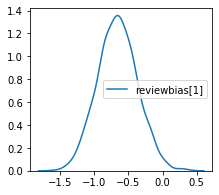

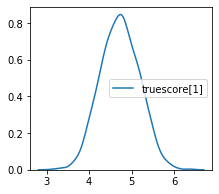

In [82]:
get_plots(fit)

In [83]:
#Model 3
base_data = {'I': 810, 'N': 5000, 'J':511, 'scores':training_data[2], 'helpfulness':training_data[3], 'reviewerID':training_data[0], 'prodID':training_data[1]}

sm = pystan.StanModel(model_code=model3)

fit = sm.sampling(data=base_data, iter=1000, chains=4,warmup = 500)

# print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_472c38b06f4dc73b2bb8f0dfd5b8d443 NOW.


KeyboardInterrupt: 

In [ ]:
la = fit.extract(permuted=False)
getRMSEscores(la,"3")

In [ ]:
get_plots(fit)

In [84]:
#Model 4 (tuned priors w/o s.a. )
base_data = {'I': 810, 'N': 5000, 'J':511, 'scores':training_data[2], 'helpfulness':training_data[3], 'reviewerID':training_data[0], 'prodID':training_data[1]}

sm = pystan.StanModel(model_code=model4)

fit = sm.sampling(data=base_data, iter=1000, chains=4,warmup = 500)

# print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_63c8f084427103f2e4a49232ea47125a NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [85]:
la = fit.extract(permuted=False)
getRMSEscores(la,"4")

Training RMSE for Model 4 0.7777553293212005
Testing RMSE for Model 4 0.9933978905515947


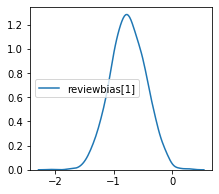

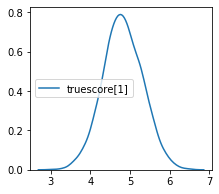

In [86]:
get_plots(fit)

In [ ]:
#Model 5
# base_data = {'I': 810, 'N': 5000, 'J':511, 'scores':training_data[2], 'sentscore':training_data[4], 'reviewerID':training_data[0], 'prodID':training_data[1]}

# sm = pystan.StanModel(model_code=model5)

# fit = sm.sampling(data=base_data, iter=1000, chains=4,warmup = 500)

# print(fit)


In [ ]:
print(len(reviewQuality_tb),len(reviewQuality),len(training_data[4]))

In [87]:
#Model 6(Sentiment Analysis using TB)
base_data = {'I': 810, 'N': 5000, 'J':511, 'scores':training_data[2], 'sentscore':training_data[6], 'reviewerID':training_data[0], 'prodID':training_data[1]}

sm = pystan.StanModel(model_code=model2)

fit = sm.sampling(data=base_data, iter=1000, chains=4,warmup = 500)

# print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c8cf4b0ae2a4eb09989344aeaa76d3ee NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [88]:
la = fit.extract(permuted=False)
getRMSEscores(la,"6")

Training RMSE for Model 6 0.7917089288964969
Testing RMSE for Model 6 0.9924208425665009


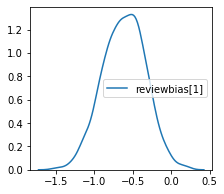

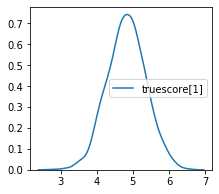

In [89]:
get_plots(fit)

In [64]:
def get_plots(fit):
    fit_df=fit.to_dataframe()
    plot_bias(rusers,fit_df)
    plot_goodness(rproducts,fit_df)


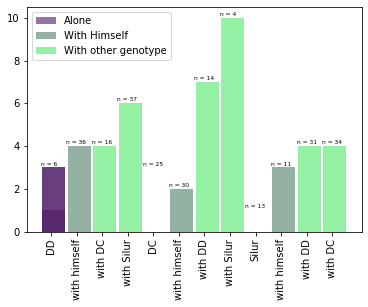

In [49]:
# library
import matplotlib.pyplot as plt

# Create bars
barWidth = 0.9
bars1 = [1]
bars2 = [4, 2, 3]
bars3 = [4, 6, 7, 10, 4, 4]
bars4 = bars1 + bars2 + bars3

# The X position of bars
r1 = [1,5,9]
# r2 = [2,6,10]
# r3 = [3,4,7,8,11,12]
r4 = r1 + r2 + r3
r4 = r1

r1 = [1]

# Create barplot
plt.bar(r1, bars1, width = barWidth, color = (0.3,0.1,0.4,0.6), label='1')
# plt.bar(r2, bars2, width = barWidth, color = (0.3,0.5,0.4,0.6), label='With Himself')
# plt.bar(r3, bars3, width = barWidth, color = (0.3,0.9,0.4,0.6), label='With other genotype')
# Note: the barplot could be created easily. See the barplot section for other examples.

# Create legend
plt.legend()

# Text below each barplot with a rotation at 90°
plt.xticks([r + barWidth for r in range(len(r4))], ['DD', 'with himself', 'with DC', 'with Silur', 'DC', 'with himself', 'with DD', 'with Silur', 'Silur', 'with himself', 'with DD', 'with DC'], rotation=90)

# Create labels
label = ['n = 6', 'n = 25', 'n = 13', 'n = 36', 'n = 30', 'n = 11', 'n = 16', 'n = 37', 'n = 14', 'n = 4', 'n = 31', 'n = 34']

# Text on the top of each barplot
for i in range(len(r4)):
    plt.text(x = r4[i]-0.5 , y = bars4[i]+0.1, s = label[i], size = 6)

# Adjust the margins
plt.subplots_adjust(bottom= 0.2, top = 0.98)

# Show graphic
plt.show()
